## -- 1. 样本介绍 & 数据读取 --
**Ref: https://github.com/NLP-LOVE/ML-NLP** <br>
/Users/samxie/Research/Match_AI/Discuss/Product_Creator_In_20250407_220618.csv <br>
/Users/samxie/Research/Match_AI/Discuss/Creator_List.csv <br>
**聚类：商品类别 verse 达人类，寻找两类关系** <br>

### 达人维度数据:
Affiliate GMV, <br> 
Affiliate LIVE GMV, <br>
Affiliate shoppable video GMV, <br>
Affiliate product card, <br> 
GMV	Affiliate products sold, <br>
Items sold,	<br>
Est. commission, <br>
Avg. order value, <br>
Affiliate product showcase,	<br>
Affiliate orders, <br>
CTR, <br>
Product impressions, <br>
Avg. affiliate customers, <br>
Affiliate LIVEs, <br>
Affiliate shoppable videos,	<br>
Target collaboration GMV, <br>
Target collaboration est. commission, <br>
Open collaboration GMV,	<br>
Open collaboration est. commission,	<br>
Affiliate refunded GMV,	<br>
Affiliate items refunded, <br>
Affiliate followers, <br>
ROI <br>
### 商品维度数据:
视频标题, <br>
视频时长, <br>
达人粉丝数, <br>
国家/地区, <br>
发布时间, <br>
播放量, <br>
点赞数, <br>
互动率, <br>
该商品销量, <br>
该商品销售额, <br>
商品标题, <br>	
单销售价格, <br>	
单总销售件数, <br>	
单总GMV, <br>
单关联视频数, <br>	
单评论数, <br>
单评分, <br>	
单近28天销售件数, <br>
单近28天销售额, <br>
单近28天带货达人数量, <br>
单近28天带货视频数量, <br>
单近28天带货直播数量, <br>
单近28天视频销售额, <br>
单近28天直播销售额

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import sparse
import warnings
import re
from langdetect import detect
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
creator_df = pd.read_csv('/Users/samxie/Research/Match_AI/Discuss/Creator_List.csv')
creator_df.head()

,Creator_username,Affiliate_GMV,Affiliate_LIVE_GMV,Affiliate_shoppable_video_GMV,Affiliate_product_card_GMV,Affiliate_products_sold,Items_sold,Est_commission,Avg_order_value,Affiliate_product_showcase,...,Affiliate_LIVEs,Affiliate_shoppable_videos,Target_collaboration_GMV,Target_collaboration_est_commission,Open_collaboration_GMV,Open_collaboration_est_commission,Affiliate_refunded_GMV,Affiliate_items_refunded,Affiliate_followers,ROI
0,dinastee,2.130662e+08,0.00,2.129886e+08,77566.0,8,2557,19214046.00,85466.00,0,...,0,5,0.00,0.00,2.125906e+08,9906956.00,29632232.00,340,30174.0,10.089084
1,darleneserrano2,7.628796e+05,1239.06,7.598715e+05,1769.0,5,2543,27050.05,307.86,0,...,4,11,0.00,0.00,7.628796e+05,12224.86,80733.89,269,8264.0,27.202519
2,jomaryeedump_,6.342531e+05,0.00,6.325831e+05,1670.0,6,2159,49543.80,303.33,0,...,0,0,0.00,0.00,6.342531e+05,49543.80,78457.22,268,2561482.0,11.801867
3,anjbbln,3.675751e+05,0.00,3.627377e+05,4837.4,10,1642,28144.23,256.87,0,...,0,14,0.00,0.00,3.675751e+05,28144.23,60127.53,168,25981.0,12.060407
4,iamadrian07,4.266763e+05,406364.46,1.995083e+04,361.0,28,1541,41039.45,331.01,0,...,31,0,187820.29,22732.99,2.388560e+05,18275.00,103645.27,255,375665.0,9.396735


In [3]:
product_df = pd.read_excel('/Users/samxie/Research/Match_AI/Discuss/Product_Creator_OCRAll_20250407_220618.xlsx')
product_df.head()

,Creator_username,Affiliate_GMV,Affiliate_LIVE_GMV,Affiliate_shoppable_video_GMV,Affiliate_product_card_GMV,Affiliate_products_sold,Items_sold,Est_commission,Avg_order_value,Affiliate_product_showcase,...,单近28天销售额,单近28天带货达人数量,单近28天带货视频数量,单近28天带货直播数量,单近28天视频销售额,单近28天直播销售额,商品类别,商品介绍,功能特性,商品类
0,jomaryeedump.,634253.12,0.00,632583.12,1670.0,6,2159,49543.80,303.33,0,...,2410.87万,1923,4244,2143,229.92万,2073.00万,Handheld fan,GOOJODOQ turbine motor fan with strong airflow...,16000 RPM motor; low noise <25dB; 100 speed le...,Electronics
1,iamadrian07,426676.29,406364.46,19950.83,361.0,28,1541,41039.45,331.01,0,...,323.8475万,2,0,6,29.93万,245.36万,Handheld fan,GOOJODOQ high-speed turbine fan with seamless ...,16000RPM motor; <25dB noise; 100 wind speeds; ...,Electronics
2,iamadrian07,426676.29,406364.46,19950.83,361.0,28,1541,41039.45,331.01,0,...,5.98万,17,30,40,1.17万,0,Sticker decoration,Glass rhinestone stickers with adhesive backin...,Includes 54pcs × 90pcs per pack. 20cm x 12cm i...,Storage/Home
3,iamadrian07,426676.29,406364.46,19950.83,361.0,28,1541,41039.45,331.01,0,...,2410.87万,1923,4244,2143,229.92万,2073.00万,Handheld fan,GOOJODOQ turbine motor fan with strong airflow...,16000 RPM motor; low noise <25dB; 100 speed le...,Electronics
4,goojodoq.philippines,382191.08,377616.02,4575.06,0.0,20,843,33769.81,557.94,0,...,2410.87万,1923,4244,2143,229.92万,2073.00万,Handheld fan,GOOJODOQ turbine motor fan with strong airflow...,16000 RPM motor; low noise <25dB; 100 speed le...,Electronics


## -- 2. 特征工程 --

### -- 2.1 商品侧 --

In [7]:
## 2.1.1 BERT 编码
device = torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertmodel = BertModel.from_pretrained('bert-base-uncased').to(device)
bertmodel.eval()

def bert_encode(texts, batch_size=16, max_length=128, random_state=None):
    """
    使用 BERT 对文本列表进行编码，支持可选随机数种子以保证可重复性。

    Para：
    -----------
    - texts: List[str]，要编码的文本列表。
    - batch_size: int，批大小。
    - max_length: int，最大序列长度。
    - random_state: int or None，如果不为 None，则设置 numpy 和 torch 的随机种子。

    Reture：
    -----------
    - np.ndarray, shape=(len(texts), hidden_size)，每条文本的平均池化向量。
    """
    # 可选：设置随机种子，保证可重复性
    if random_state is not None:
        np.random.seed(random_state)
        torch.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)

    vectors = []
    for i in tqdm(range(0, len(texts), batch_size), desc="BERT Encoding"):
        batch = texts[i : i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=max_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bertmodel(**inputs)
        # 对 last_hidden_state 做平均池化
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        vectors.append(emb)
    return np.vstack(vectors)

TAGALOG_STOPWORDS = {
    'ang','sa','ng','na','mga','ako','ikaw','siya','kami','tayo','ito','iyan',
    'iyon','daw','raw','ay','mismo','lamang','pa','din','rin','kasi','pero'
}

def preprocess_multilang(text: str) -> str:
    """
    先检测 text 主要语言，然后用相应的停用词列表清洗并返回处理后的字符串。
    """
    # 小写 & 保留中/英/Tagalog 字母与数字
    txt = text.lower()
    txt = re.sub(r'[^0-9a-z\u4e00-\u9fa5\s]', ' ', txt)
    tokens = txt.split()
    
    try:
        lang = detect(txt)
    except:
        lang = 'en'
    
    if lang == 'tl':
        tokens = [t for t in tokens if t not in TAGALOG_STOPWORDS]
    else:
        tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

def bert_encode_multilang(
    texts, batch_size=16, max_length=128, random_state=None
):
    """
    对 texts（含多语言）先调用 preprocess_multilang，再用 BERT 编码。
    """
    if random_state is not None:
        np.random.seed(random_state)
        torch.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)
    
    processed = [preprocess_multilang(t) for t in texts]
    vectors = []
    for i in tqdm(range(0, len(processed), batch_size), desc="BERT Encoding"):
        batch = processed[i:i+batch_size]
        inputs = tokenizer(
            batch, padding=True, truncation=True,
            return_tensors='pt', max_length=max_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            out = bertmodel(**inputs)
        emb = out.last_hidden_state.mean(dim=1).cpu().numpy()
        vectors.append(emb)
    return np.vstack(vectors)

combined_titles = (
    product_df['视频标题'].fillna('') + ' ' +
    product_df['商品标题'].fillna('') + ' ' +
    product_df['商品介绍'].fillna('') + ' ' +   
    product_df['功能特性'].fillna('')
).astype(str).tolist()

title_vecs = bert_encode_multilang(
    combined_titles,
    batch_size=16,
    max_length=128,
    random_state=202504
)

X_title_bert = sparse.csr_matrix(title_vecs)
svd = TruncatedSVD(n_components=50, random_state=202504)
X_title_bert = svd.fit_transform(X_title_bert)
print("合并标题的 BERT 特征维度：", X_title_bert.shape)

BERT Encoding: 100%|██████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


合并标题的 BERT 特征维度： (2155, 50)


In [96]:
## 2.1.2 数值特征：标准化
num_prod_cols = [
    '视频时长', '播放量', '点赞数', '互动率',
    '该商品销量', '该商品销售额', 
    '单销售价格', '单评分'
]

scaler_prod = StandardScaler()
X_num_prod = scaler_prod.fit_transform(product_df[num_prod_cols].fillna(0))

# 2.1.3 商品类别
ohe_category = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_category = ohe_category.fit_transform(
    product_df[['商品类', '商品类别']].fillna('NA')
)
print("商品类目 One-Hot 编码后形状：", X_category.shape)

# 2.1.4 完整矩阵
X_product = sparse.hstack([
    sparse.csr_matrix(X_title_bert),
    sparse.csr_matrix(X_num_prod)
], format='csr')

print("X_title_bert:", X_title_bert.shape)
print("X_num_prod:", X_num_prod.shape)
print("X_category:", X_category.shape)

print("最终商品特征矩阵 X_product 形状：", X_product.shape)

商品类目 One-Hot 编码后形状： (2155, 60)
X_title_bert: (2155, 50)
X_num_prod: (2155, 8)
X_category: (2155, 60)
最终商品特征矩阵 X_product 形状： (2155, 58)


**构建商品类别预测模型，后续可以根据商品介绍锁定类型簇**

In [77]:
# 合并文本列作为输入
product_df['商品文本'] = (
    product_df['视频标题'].fillna('') + ' ' +
    product_df['商品标题'].fillna('') + ' ' +
    product_df['商品介绍'].fillna('') + ' ' +
    product_df['功能特性'].fillna('')
).astype(str)

X_text = product_df['商品文本'].tolist()
y_class     = product_df['商品类'].astype(str)       # 预测大类
y_subclass  = product_df['商品类别'].astype(str)     # 预测小类

# BERT编码 + SVD降维
text_vecs = bert_encode_multilang(X_text, batch_size=16, random_state=202504)
# 降维为30维，或者更小？
svd_cat = TruncatedSVD(n_components=50, random_state=202504)
X_cat = svd_cat.fit_transform(sparse.csr_matrix(text_vecs))

from sklearn.linear_model import LogisticRegression
clf_class = LogisticRegression(max_iter=1000, random_state=202504)
clf_subclass = LogisticRegression(max_iter=1000, random_state=202504)
clf_class.fit(X_cat, y_class)
clf_subclass.fit(X_cat, y_subclass)

def predict_product_category(text):
    vec = bert_encode_multilang([text])                  # (1,768)
    vec = svd_cat.transform(sparse.csr_matrix(vec))      # (1,30)

    pred_class = clf_class.predict(vec)[0]
    pred_subclass = clf_subclass.predict(vec)[0]

    return pred_class, pred_subclass

BERT Encoding: 100%|██████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


In [78]:
# 效果还行，毕竟数据集真的太少
predict_product_category("iphone")
# predict_product_category("Computer Macbook")

BERT Encoding: 100%|██████████████████████████████| 1/1 [00:00<00:00, 14.21it/s]


('Electronics', 'fan')

In [79]:
import joblib
# 保存降维器和分类器
joblib.dump(svd_cat, './model/svd_cat.pkl')
joblib.dump(clf_class, './model/clf_class.pkl')
joblib.dump(clf_subclass, './model/clf_subclass.pkl')

['./model/clf_subclass.pkl']

In [80]:
import joblib
# 加载降维器和分类器
svd_cat = joblib.load('./model/svd_cat.pkl')
clf_class = joblib.load('./model/clf_class.pkl')
clf_subclass = joblib.load('./model/clf_subclass.pkl')
# 调用
def predict_product_category(product_desc: str) -> tuple[str, str]:
    # BERT 编码（768维） → 降维（30维）
    vec = bert_encode_multilang([product_desc])           # (1,768)
    vec_svd = svd_cat.transform(sparse.csr_matrix(vec))   # (1,30)
    # 分类
    pred_class = clf_class.predict(vec_svd)[0]
    pred_subclass = clf_subclass.predict(vec_svd)[0]
    return pred_class, pred_subclass

### -- 2.2 达人侧特征工程 --

In [81]:
# 2.2.1 数值特征：直接标准化
num_cre_cols = [
    'Affiliate_GMV', 'Affiliate_LIVE_GMV',
    'Affiliate_shoppable_video_GMV', 'Affiliate_product_card_GMV',
    'Affiliate_products_sold', 'Items_sold', 'Est_commission',
    'Avg_order_value', 'Affiliate_product_showcase', 'Affiliate_orders',
    'CTR', 'Product_impressions', 'Avg_affiliate_customers',
    'Affiliate_LIVEs', 'Affiliate_shoppable_videos',
    'Target_collaboration_GMV', 'Target_collaboration_est_commission',
    'Open_collaboration_GMV', 'Open_collaboration_est_commission',
    'Affiliate_refunded_GMV', 'Affiliate_items_refunded',
    'Affiliate_followers', 'ROI'
]

scaler_cre = StandardScaler()

# 达人有效样本，来自于product数据集中已经和商品匹配上的达人维度信息
X_creator_eff = sparse.csr_matrix(
    scaler_cre.fit_transform(product_df[num_cre_cols].fillna(0))
)
print("有效样本达人特征矩阵 X_creator_eff 形状：", X_creator_eff.shape)

# 达人总样本，来自于Creator数据集，共有25112位达人
X_creator = sparse.csr_matrix(
    scaler_cre.transform(creator_df[num_cre_cols].fillna(0))
)
print("全样本达人特征矩阵 X_creator 形状：", X_creator.shape)

有效样本达人特征矩阵 X_creator_eff 形状： (2155, 23)
全样本达人特征矩阵 X_creator 形状： (252112, 23)


## -- 3. 聚类 --

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# 假设前面已完成特征工程，得到：
#   X_product            # (n_products × D_p) 稀疏矩阵
#   product_df           # 包含 1500+ 条商品记录的 DataFrame
#   X_creator_full       # (n_all_creators × D_c) 稀疏矩阵
#   creator_df           # 包含 250k 条达人记录的 DataFrame

###  -- 3.1 达人聚类 --

开始评估不同聚类数下的指标...
K= 3 | Silhouette=0.7027 | CH=524.4 | DB=1.2090
K= 4 | Silhouette=0.4869 | CH=377.5 | DB=1.2498
K= 5 | Silhouette=0.5654 | CH=293.1 | DB=1.2736
K= 6 | Silhouette=0.4915 | CH=251.9 | DB=1.6839
K= 7 | Silhouette=0.2151 | CH=204.6 | DB=1.5895
K= 8 | Silhouette=0.3795 | CH=175.7 | DB=1.4102
K= 9 | Silhouette=0.2276 | CH=161.1 | DB=1.3487
K=10 | Silhouette=0.4254 | CH=146.9 | DB=1.4181
K=11 | Silhouette=0.3551 | CH=149.9 | DB=1.2123
K=12 | Silhouette=0.2958 | CH=135.8 | DB=1.2242
K=13 | Silhouette=0.5236 | CH=139.7 | DB=1.1821
K=14 | Silhouette=0.3328 | CH=113.7 | DB=1.3000


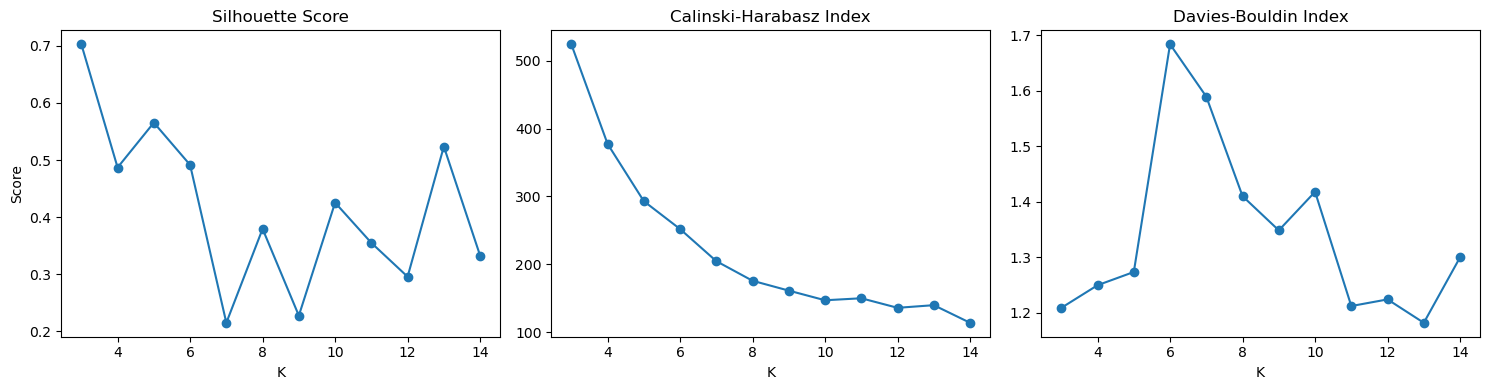

In [15]:
# 选出训练集中的最佳聚类
K_range = range(3, 15)
scores = []

print("开始评估不同聚类数下的指标...")

for k in K_range:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=202504,
        batch_size=64,
        n_init='auto'
    )
    labels = km.fit_predict(X_creator_eff)

    sil_score = silhouette_score(X_creator_eff, labels)
    ch_score = calinski_harabasz_score(X_creator_eff.toarray(), labels)
    db_score = davies_bouldin_score(X_creator_eff.toarray(), labels)

    print(f"K={k:2d} | Silhouette={sil_score:.4f} | CH={ch_score:.1f} | DB={db_score:.4f}")
    scores.append((k, sil_score, ch_score, db_score))

# 转为 DataFrame
df_scores = pd.DataFrame(scores, columns=['K', 'Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin'])

# ----------------------------
# 可视化评估指标
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(df_scores['K'], df_scores['Silhouette'], marker='o')
plt.title("Silhouette Score")
plt.xlabel("K"); plt.ylabel("Score")

plt.subplot(1, 3, 2)
plt.plot(df_scores['K'], df_scores['Calinski_Harabasz'], marker='o')
plt.title("Calinski-Harabasz Index")
plt.xlabel("K")

plt.subplot(1, 3, 3)
plt.plot(df_scores['K'], df_scores['Davies_Bouldin'], marker='o')
plt.title("Davies-Bouldin Index")
plt.xlabel("K")

plt.tight_layout()
plt.show()

In [82]:
# 最终聚类器 - k = 3
K_creator_final = 3
creator_km = MiniBatchKMeans(
    n_clusters=K_creator_final,
    random_state=202505,
    batch_size=64,
    n_init='auto'
)

# 聚类达人有效样本
creator_eff_labels = creator_km.fit_predict(X_creator_eff)

# 写入标签
creator_eff_df = product_df.loc[:, ['Creator_username'] + num_cre_cols].copy()
creator_eff_df['CreatorClusterID'] = creator_eff_labels

In [83]:
# 3.2.3 将聚类模型应用到全量达人池
full_labels = creator_km.predict(X_creator)
creator_df['CreatorClusterID'] = full_labels

In [84]:
# 3.2.4 查看分布
print("有效达人簇分布：")
print(creator_eff_df['CreatorClusterID'].value_counts().sort_index())
print("\n全量达人簇分布：")
print(creator_df['CreatorClusterID'].value_counts().sort_index())

有效达人簇分布：
CreatorClusterID
0     323
1    1605
2     227
Name: count, dtype: int64

全量达人簇分布：
CreatorClusterID
0      4513
1    235679
2     11920
Name: count, dtype: int64


## -- 4. 簇间关系建模 --

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 通过刚刚的代码，环境中已有：——
# product_df      # 有效样本 DataFrame，含 'ProductClusterID' 列
# creator_eff_df  # 有效达人 DataFrame，含 'CreatorClusterID' 列
# creator_df      # 全量达人 DataFrame，含 'CreatorClusterID' 列
# X_product       # 稀疏矩阵，对应 product_df 行，商品特征
# num_cre_cols    # 列表，product_df 中的达人数值特征列

In [98]:
# 4.1 将有效达人簇合并到 product_df
product_eff = product_df.copy()
product_eff['CreatorClusterID'] = creator_eff_labels

print("有效 product_df 形状：", product_df.shape)
print("有效 creator_eff_df 形状：", creator_eff_df.shape)
print("有效 product_eff 形状：", product_eff.shape)
# 检查合并情况
assert product_eff['CreatorClusterID'].isna().sum() == 0, "有合并失败的达人！"

有效 product_df 形状： (2155, 65)
有效 creator_eff_df 形状： (2155, 25)
有效 product_eff 形状： (2155, 66)


In [99]:
# 4.2 计算簇-簇聚合统计：选取的这四个维度是否合理？
# 保证类型统一
product_eff['商品类别'] = product_eff['商品类别'].astype(str)
product_eff['CreatorClusterID'] = product_eff['CreatorClusterID'].astype(int)

# 聚合统计 ROI / GMV / 销量等指标
agg = product_eff.groupby(['商品类别', 'CreatorClusterID']).agg(
    avg_ROI=('ROI', 'mean'),
    avg_GMV=('Affiliate_GMV', 'mean'),
    total_items_sold=('Items_sold', 'sum'),
    total_impressions=('Product_impressions', 'sum')
).reset_index()

# 转化率指标
agg['conversion_rate'] = agg['total_items_sold'] / agg['total_impressions'].replace(0, np.nan)

In [88]:
# 4.3 构建簇交互矩阵 M_ROI
M_ROI = agg.pivot(index='商品类别', columns='CreatorClusterID', values='avg_ROI').fillna(0)
print("构建完成的 M_ROI 矩阵形状：", M_ROI.shape)

import joblib
joblib.dump(M_ROI, "./model/M_ROI_matrix.pkl")

构建完成的 M_ROI 矩阵形状： (53, 3)


['./model/M_ROI_matrix.pkl']

In [100]:
# 4.4 训练样本
enc_c = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
C_ohe = enc_c.fit_transform(product_eff[['CreatorClusterID']])
enc_p = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
P_ohe = enc_p.fit_transform(product_eff[['商品类别']].astype(str))

def get_mroi(row):
    cat = row['商品类别']
    cluster = row['CreatorClusterID']
    try:
        return M_ROI.loc[cat, cluster]
    except:
        return 0  # 没有记录时为0或填均值

product_eff['M_ROI_value'] = product_eff.apply(get_mroi, axis=1)

X_prod_dense = X_product.toarray()  # 商品特征
X_cre_feat = product_eff[num_cre_cols].fillna(0).values  # 达人特征
X_mroi = product_eff[['M_ROI_value']].values  # 加入交互项（1列）


# 拼接成总特征矩阵
X_all = np.hstack([P_ohe, C_ohe, X_prod_dense, X_cre_feat, X_mroi])
y = product_eff['ROI'].values

# 清洗标签
y_raw = product_eff['ROI'].values
not_null_idx = ~pd.isna(y_raw)
X_all_clean = X_all[not_null_idx]
y_clean_log = np.log1p(np.clip(y_raw[not_null_idx], 0, 300))
print("训练标签（log1p 后）最大值：", y_clean_log.max())
print("训练标签（log1p 后）分布：")
print(pd.Series(y_clean_log).describe())

训练标签（log1p 后）最大值： 3.7185281479461785
训练标签（log1p 后）分布：
count    2155.000000
mean        0.393974
std         0.933465
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.718528
dtype: float64


XGBoost Test RMSE: 0.0319
XGBoost Test R²:   0.9988


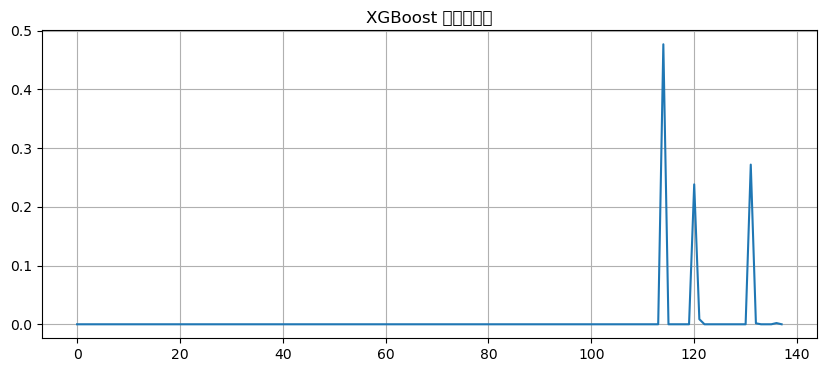

y_pred_log describe:
count    647.000000
mean       0.387764
std        0.931711
min       -0.000094
25%        0.000009
50%        0.000009
75%        0.000009
max        3.695653
dtype: float64
最大预测 ROI（还原后）: 39.27186


In [111]:
# 4.5 训练，用什么模型更好？怎么调？
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_all_clean, y_clean_log,  # 仍用 log1p 后的 y
    test_size=0.3,
    random_state=202504
)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 回归模型
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=202504,
    n_jobs=-1
)
model_xgb.fit(X_train_scaled, y_train)

# 预测 + 还原
y_pred_log = model_xgb.predict(X_test_scaled)
y_pred = np.expm1(np.clip(y_pred_log, 0, 6))
y_true = np.expm1(y_test)

# 评估
rmse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"XGBoost Test RMSE: {rmse:.4f}")
print(f"XGBoost Test R²:   {r2:.4f}")

# 特征重要性
importances = model_xgb.feature_importances_
plt.figure(figsize=(10, 4))
plt.plot(importances)
plt.title("XGBoost 特征重要性")
plt.grid(True)
plt.show()

# 预测结果概览
print("y_pred_log describe:")
print(pd.Series(y_pred_log).describe())
print("最大预测 ROI（还原后）:", np.expm1(y_pred_log).max())

**有个问题：**就是模型到底怎么样才算好？rmse越低，r2越高就真的对我们的预测越好吗？

## -- 5. 商品介绍—达人匹配 --

In [112]:
def recommend_online_ridge(
    product_desc: str,
    bert_tokenizer,
    bert_model,
    scaler_prod,
    ohe_region,
    scaler_cre,
    num_cre_cols,
    creator_df,
    enc_p,              # 商品类别 OneHotEncoder
    enc_c,              # 达人簇 OneHotEncoder
    M_ROI,              # 类目 × 达人簇 ROI 交互矩阵
    model_ridge,        # 回归模型
    ridge_scaler,       # 特征标准化器
    svd_cat,            # 商品文本降维器
    clf_subclass,       # 小类分类器
    top_k=10
):
    # 1. 文本编码 + SVD 降维
    vec = bert_encode_multilang([product_desc])
    vec = svd_cat.transform(sparse.csr_matrix(vec))  # shape: (1, 50)

    # 2. 预测商品类别（小类）
    pred_subclass = clf_subclass.predict(vec)[0]
    P_ohe = enc_p.transform([[pred_subclass]])       # shape: (1, 53)

    # 3. 构造商品特征（使用 0 向量填充数值、时间、区域、类别）
    zero_num = np.zeros((1, scaler_prod.mean_.shape[0]))                         # 商品数值
    zero_cat = np.zeros((1, ohe_category.transform([['NA', 'NA']]).shape[1]))   # 类目 One-hot

    X_prod = np.hstack([vec, zero_num])       # shape: (1, 102)

    # --------- 批量处理所有达人 ---------
    n_creators = creator_df.shape[0]
    X_prod_repeat = np.repeat(X_prod, n_creators, axis=0)  # (n, 102)

    X_cre = creator_df[num_cre_cols].fillna(0).infer_objects(copy=False).values  # (n, 23)
    C_ohe = enc_c.transform(creator_df[['CreatorClusterID']])                    # (n, C)
    P_ohe_repeat = np.repeat(P_ohe, n_creators, axis=0)                          # (n, 53)

    # M_ROI 批量查表（商品类目 × 达人簇）
    cluster_ids = creator_df['CreatorClusterID'].values
    mroi_vals = np.array([
        M_ROI.loc[pred_subclass, cid] if cid in M_ROI.columns else 0.0
        for cid in cluster_ids
    ]).reshape(-1, 1)  # shape: (n, 1)

    # 拼接特征
    X_all_pred = np.hstack([
        P_ohe_repeat,      # 商品类目 one-hot
        C_ohe,             # 达人簇 one-hot
        X_prod_repeat,     # 商品特征（重复）
        X_cre,             # 达人特征
        mroi_vals          # ROI交互项
    ])  # shape: (n, 182)

    # 标准化 + 预测
    X_all_scaled = ridge_scaler.fit_transform(X_all_pred)
    pred_rois = model_ridge.predict(X_all_scaled) 

    # 生成推荐结果表
    result_df = creator_df[['Creator_username', 'CreatorClusterID']].copy()
    result_df['预测ROI'] = pred_rois
    result_df = result_df.sort_values('预测ROI', ascending=False).head(top_k)

    return result_df

In [113]:
product_desc_list = [
    "A portable electric fan with rechargeable battery and quiet mode.",
    "High-quality wireless Bluetooth headphones with noise cancellation.",
    ""
]

for desc in product_desc_list:
    print(f"\n📦 推荐结果 - 产品描述: '{desc}'")
    recs = recommend_online_ridge(
        product_desc=desc,
        bert_tokenizer=tokenizer,
        bert_model=bertmodel,
        scaler_prod=scaler_prod,
        ohe_region=ohe_region,
        scaler_cre=scaler_cre,
        num_cre_cols=num_cre_cols,
        creator_df=creator_df,
        enc_p=enc_p,
        enc_c=enc_c,
        M_ROI=M_ROI,
        model_ridge=model_ridge,
        ridge_scaler=ridge_scaler,
        svd_cat=svd_cat,
        clf_subclass=clf_subclass,
        top_k=10
    )
    print(recs)


📦 推荐结果 - 产品描述: 'A portable electric fan with rechargeable battery and quiet mode.'


BERT Encoding: 100%|██████████████████████████████| 1/1 [00:00<00:00, 15.92it/s]


          Creator_username  CreatorClusterID      预测ROI
4              iamadrian07                 0  45.251774
2            jomaryeedump_                 0  39.788204
3                  anjbbln                 0  33.452883
1          darleneserrano2                 0  32.516166
14    goojodoq.philippines                 0  30.586303
5                 zam_1925                 0  30.413991
6            syarlinjasmin                 0  27.815136
1379           czarin0aa_c                 0  25.245501
8               win_tech06                 0  24.902105
11             ya0sanmateo                 0  23.660295

📦 推荐结果 - 产品描述: 'High-quality wireless Bluetooth headphones with noise cancellation.'


BERT Encoding: 100%|██████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]


          Creator_username  CreatorClusterID      预测ROI
4              iamadrian07                 0  45.251774
2            jomaryeedump_                 0  39.788204
3                  anjbbln                 0  33.452883
1          darleneserrano2                 0  32.516166
14    goojodoq.philippines                 0  30.586303
5                 zam_1925                 0  30.413991
6            syarlinjasmin                 0  27.815136
1379           czarin0aa_c                 0  25.245501
8               win_tech06                 0  24.902105
11             ya0sanmateo                 0  23.660295

📦 推荐结果 - 产品描述: ''


BERT Encoding: 100%|██████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


          Creator_username  CreatorClusterID      预测ROI
4              iamadrian07                 0  45.251774
2            jomaryeedump_                 0  39.788205
3                  anjbbln                 0  33.452883
1          darleneserrano2                 0  32.516166
14    goojodoq.philippines                 0  30.586304
5                 zam_1925                 0  30.413991
6            syarlinjasmin                 0  27.815137
1379           czarin0aa_c                 0  25.245501
8               win_tech06                 0  24.902106
11             ya0sanmateo                 0  23.660296


In [114]:
vec1 = bert_encode_multilang(["A portable electric fan with rechargeable battery and quiet mode."])
vec2 = bert_encode_multilang(["High-quality wireless Bluetooth headphones with noise cancellation."])
vec3 = bert_encode_multilang([""])

from sklearn.metrics.pairwise import cosine_similarity
print("Text vector similarity:")
print("1 vs 2:", cosine_similarity(vec1, vec2)[0][0])
print("1 vs 3:", cosine_similarity(vec1, vec3)[0][0])
print("2 vs 3:", cosine_similarity(vec2, vec3)[0][0])

BERT Encoding: 100%|██████████████████████████████| 1/1 [00:00<00:00, 25.51it/s]

Text vector similarity:
1 vs 2: 0.72707295
1 vs 3: 0.3871469
2 vs 3: 0.36593673
